# Numpy -  advanced indexing and filtering
## Introduction
Assigning values to large arrays using numpy advanced indexing is a breeze, especially with the [ix\_](http://docs.scipy.org/doc/numpy/reference/generated/numpy.ix_.html) function. However, when filtering values, say you only want to replace non-NaN elements in the target array, there are many different approaches. One appealing choice is the MaskedArray class in  numpy. However, using masks is very slow - the time spent for an assignment quadruples. Presented below are some ways I tried while hunting for better performance, some more clever than others. 
## Environment
While testing the different approaches, I used [Anaconda](https://www.continuum.io/) 4.0.0, with Python 3.5.2 and numpy 1.11.0. Numba version was 0.28.1 and seaborn was used for (prettier) plotting.

In [24]:
import numpy as np
import numba
import timeit
import seaborn
%matplotlib inline
seaborn.plt.rcParams['figure.figsize'] = (12, 6)

## Starting point
Say our large array has the dimensions 150x10000, and we want to assign 100x1000 values which are spread all over the array.

In [25]:
# Array and replacement dimensions
n_x = 150
n_y = 10000
repl_x = 100
repl_y = 1000

# Our large array of random numbers - uniform distribution between 0 and 1
large_array = np.random.randn(n_x*n_y).astype(np.float32).reshape(n_x, n_y)

# Our replacement indices and values
ind_x = np.random.choice(np.arange(n_x), repl_x, replace=False)
ind_y = np.random.choice(np.arange(n_y), repl_y, replace=False)
repl = np.full([repl_x, repl_y], -255.0).astype(np.float32) #  Replacement values are all the same here for convenience
idx_to = np.ix_(ind_x, ind_y)
arraycc = large_array.copy()

# Normal assignment without filtering - replaces 100000 values with -255
arraycc[idx_to] = repl
print("Elements which were replaced:", np.sum(arraycc == -255.0))

Elements which were replaced: 100000


In [26]:
# Average time for a replacement
def assign():
    idx_to = np.ix_(ind_x, ind_y)
    arraycc[idx_to] = repl

t_pure_fill = timeit.timeit(assign, number = 1000) / 1000 * 1000
print("%.3f ms" % t_pure_fill)    

# Store times for later use
t = []
col = []
t.append(t_pure_fill)
col.append("Pure fill - no filter")

1.291 ms


## The problem - filtering
Say we only want to replace values which are larger than 0.8. Lets try a naïve approach:

In [27]:
arraycc = large_array.copy()
# Number of elements we want to replace
print("Number of elements to be replaced:", np.sum(arraycc[idx_to] > 0.8))
arraycc[idx_to][arraycc[idx_to] > 0.8] = repl[arraycc[idx_to] > 0.8]
# Number of elements replaced
print("Elements which were replaced:", np.sum(arraycc == -255.0))

Number of elements to be replaced: 21167
Elements which were replaced: 0


Nothing was replaced because [**advanced indexing always returns a copy**](http://docs.scipy.org/doc/numpy/reference/arrays.indexing.html). Above arraycc is indexed twice, i.e. the indexing [arraycc[idx_to] > 0.8] is performed on a copy of arraycc. **Note that advanced indexing can be used in assigments**, as setitem is called instead of getitem, which is why arraycc[idx] = repl works.
This naïve approach is significantly slower than a normal fill as many copies are created by the advanced indexing. The naive approach can be modified to work as follows:

In [28]:
arraycc = large_array.copy()
repl_arr = repl.copy()
# Replace the undesired replacements with values from the target array
repl_arr[arraycc[idx_to] <= 0.8] = arraycc[idx_to][arraycc[idx_to] <= 0.8]
arraycc[idx_to] = repl_arr
# Number of elements replaced
print("Elements which were replaced:", np.sum(arraycc == -255.0))

# Average time for naive attempt
def assign():
    # Use large_array here for the final indexing so the function can be run many times
    idx_to = np.ix_(ind_x, ind_y)
    repl_arr[large_array[idx_to] <= 0.8] = arraycc[idx_to][large_array[idx_to] <= 0.8]
    arraycc[idx_to] = repl_arr
t_naive = timeit.timeit(assign, number = 100) / 100 * 1000
print("%.3f ms" % t_naive)
t.append(t_naive)
col.append("Naive fill - WORKS")

Elements which were replaced: 21167
8.149 ms


Lets try some other approaches.

In [29]:
arraycc = large_array.copy()
# Filter by addition modifying the replacements 
arraycc[arraycc > 0.8] = 0  # First we have to convert the values to zero - otherwise addition won't work
arraycc[idx_to] += repl*(large_array[idx_to] > 0.8)
print("Elements which were replaced:", np.sum(arraycc == -255.0))
# Average time 
def assign():
    # Use large_array here for the final indexing so the function can be run many times
    idx_to = np.ix_(ind_x, ind_y)
    arraycc[idx_to] += repl*(large_array[idx_to] > 0.8)
t_sum_mult = timeit.timeit(assign, number = 100) / 100 * 1000
print("%.3f ms" % t_sum_mult)
t.append(t_sum_mult)
col.append("Sum and multiplication - WORKS")

Elements which were replaced: 21167
5.067 ms


In [30]:
arraycc = large_array.copy()
# Filter by resizing the repl array to the same size as the large array
arraycc[arraycc > 0.8] = 1  # We have to convert the replacable values to some specific value for addition to work
filt = np.zeros_like(arraycc)
filt[idx_to] = repl - 1
filt[arraycc <= 0.8] = 0
arraycc += filt
print("Elements which were replaced:", np.sum(arraycc == -255.0))
# Average time 
def assign(arraycc):
    # Use large_array here for the final indexing so the function can be run many times
    filt = np.zeros_like(arraycc)
    idx_to = np.ix_(ind_x, ind_y)
    filt[idx_to] = repl
    filt[large_array <= 0.8] = 0
    arraycc += filt
t_resize = timeit.timeit(lambda : assign(arraycc), number = 100) / 100 * 1000
print("%.3f ms" % t_resize)
t.append(t_resize)
col.append("Resize replacement - WORKS")

Elements which were replaced: 21167
15.398 ms


Manipulating arrays seems very slow. What about manipulating the indices.
### Manipulating indices

In [31]:
arraycc = large_array.copy()

# Flattened views of arrays
rav_arraycc = arraycc.ravel()
rav_large_array = large_array.ravel()
rav_repl = repl.ravel()

# Convert indices to indices of flattened array 
coords = (((np.array(ind_x)*arraycc.shape[1])[:, None]) + np.array(ind_y)).ravel()

# Determine which indices are actually > 0.8
source_coords = np.in1d(coords, np.argwhere(rav_large_array > 0.8), assume_unique=True)

# Assing replacements
rav_arraycc[coords[source_coords]] = rav_repl[source_coords]
print("Elements which were replaced:", np.sum(rav_arraycc == -255.0))

# Average time 
def assign():
    # Use large_array here for the indexing so the function can be run many times
    coords = (((np.array(ind_x)*arraycc.shape[1])[:, None]) + np.array(ind_y)).ravel()
    source_coords = np.in1d(coords, np.argwhere(rav_large_array > 0.8), assume_unique=True)
    rav_arraycc[coords[source_coords]] = rav_repl[source_coords]

t_flattened_in1d = timeit.timeit(assign, number = 30) / 30 * 1000
print("%.3f ms" % t_flattened_in1d)
t.append(t_flattened_in1d)
col.append("Flattened in1d - WORKS")

Elements which were replaced: 21167
34.123 ms


The in1d function is very slow (likely O(n)). The behavior of in1d as the searchable array grows:

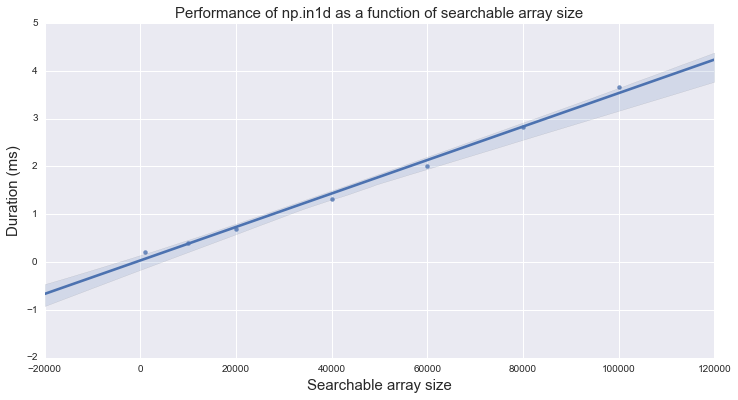

In [32]:
x_y = []
for n in [1000, 10000, 20000, 40000, 60000, 80000, 100000]:
    target = np.arange(n)
    source = np.random.choice(target, 100)
    f = lambda : np.in1d(source, target)
    x_y.append([n, (timeit.timeit(f, number=100) / 100 * 1000)])
seaborn.plt.title("Performance of np.in1d as a function of searchable array size", fontsize=15)
seaborn.regplot(np.array(x_y).T[0], np.array(x_y).T[1], 'o')
seaborn.plt.xlabel("Searchable array size", fontsize=15)
seaborn.plt.ylabel("Duration (ms)", fontsize=15)
seaborn.plt.show()

Looks pretty linear. Let's try converting the valid coordinates to a set.

In [33]:
arraycc = large_array.copy()

# Flattened views of arrays
rav_arraycc = arraycc.ravel()
rav_large_array = large_array.ravel()
rav_repl = repl.ravel()

# Convert indices to indices of flattened array 
coords = (((np.array(ind_x)*arraycc.shape[1])[:, None]) + np.array(ind_y)).ravel()
valid_coords = set(np.where(rav_large_array > 0.8)[0].tolist())

# Determine which indices are actually > 0.8
target_coords = np.array([i for i, coord in enumerate(coords) if coord in valid_coords])

# Assing replacements
rav_arraycc[coords[target_coords]] = rav_repl[target_coords]
print("Elements which were replaced:", np.sum(rav_arraycc == -255.0))

# Average time 
def assign():
    # Convert indices to indices of flattened array 
    coords = (((np.array(ind_x)*arraycc.shape[1])[:, None]) + np.array(ind_y)).ravel()
    valid_coords = set(np.where(rav_large_array > 0.8)[0].tolist())
    # Determine which indices are actually > 0.8
    target_coords = np.array([i for i, coord in enumerate(coords) if coord in valid_coords])

    # Assign replacements
    rav_arraycc[coords[target_coords]] = rav_repl[target_coords]
t_flattened_set = timeit.timeit(assign, number = 10) / 10 * 1000
print("%.3f ms" % t_flattened_set)
t.append(t_flattened_set)
col.append("Flattened set - WORKS")

Elements which were replaced: 21167
89.155 ms


Constructing a set this way is much slower. We're still looping needlessly over the array looking for values which are greater than 0.8. Only one loop over the array coming right up.

In [34]:
arraycc = large_array.copy()

# Flattened views of arrays
rav_arraycc = arraycc.ravel()
rav_large_array = large_array.ravel()
rav_repl = repl.ravel()

# Convert indices to indices of flattened array 
coords = (((np.array(ind_x)*arraycc.shape[1])[:, None]) + np.array(ind_y)).ravel()

# Assign replacements while determining which coords are actually > 0.8
for i in range(coords.size):
    if rav_large_array[coords[i]] > 0.8:
        rav_arraycc[coords[i]] = rav_repl[i]

print("Elements which were replaced:", np.sum(rav_arraycc == -255.0))
        
# Average time 
def assign():
    # Use large_array here for the indexing so the function can be run many times
    coords = (((np.array(ind_x)*arraycc.shape[1])[:, None]) + np.array(ind_y)).ravel()
    for i in range(coords.size):
        if rav_large_array[coords[i]] > 0.8:
            rav_arraycc[coords[i]] = rav_repl[i]

t_python_loop = timeit.timeit(assign, number = 4) / 4 * 1000
print("%.3f ms" % t_python_loop)
t.append(t_python_loop)
col.append("Python loop - WORKS")

Elements which were replaced: 21167
386.242 ms


Unsurprisingly, the python for-loop is extremely slow. What about using numpy [vectorize](http://docs.scipy.org/doc/numpy/reference/generated/numpy.vectorize.html)?

In [35]:
arraycc = large_array.copy()

# Flattened views of arrays
rav_arraycc = arraycc.ravel()
rav_large_array = large_array.ravel()
rav_repl = repl.ravel()

# Convert indices to indices of flattened array 
coords = (((np.array(ind_x)*arraycc.shape[1])[:, None]) + np.array(ind_y)).ravel()
coords_i = np.arange(len(coords))

# Assign replacements while determining which coords are actually > 0.8
def replace_if(c, c_i):
    if rav_large_array[c] > 0.8:
        rav_arraycc[c] = rav_repl[c_i]
    
ufunc_py_loop_coords = np.vectorize(replace_if)

ufunc_py_loop_coords(coords, coords_i)            
print("Elements which were replaced:", np.sum(rav_arraycc == -255.0))

# Average time 
def assign():
    # Use large_array here for the indexing so the function can be run many times
    coords = (((np.array(ind_x)*arraycc.shape[1])[:, None]) + np.array(ind_y)).ravel()
    coords_i = np.arange(len(coords))
    ufunc_py_loop_coords(coords, coords_i)

t_ufunc_py_loop = timeit.timeit(assign, number = 5) / 5 * 1000
print("%.3f ms" % t_ufunc_py_loop)
t.append(t_ufunc_py_loop)
col.append("Ufunc python loop - WORKS") 

Elements which were replaced: 21167
381.510 ms


Well, no help there, seems we don't want to access other arrays from our function. Perhaps a simple element-wise function over the entire replacement array.

In [36]:
arraycc = large_array.copy()

def replace_if(a, b):
    if a > 0.8:
        return b
    else:
        return a
    
vec_replace_if = np.vectorize(replace_if)

arraycc[idx_to] = vec_replace_if(arraycc[idx_to], repl)
print("Elements which were replaced:", np.sum(arraycc == -255.0))
        
# Average time 
def assign():
    # Use large_array here for the indexing so the function can be run many times
    idx_to = np.ix_(ind_x, ind_y)
    arraycc[idx_to] = vec_replace_if(large_array[idx_to], repl)

t_vec_python = timeit.timeit(assign, number = 20) / 20 * 1000
print("%.3f ms" % t_vec_python)
t.append(t_vec_python)
col.append("Vectorized python - WORKS")

Elements which were replaced: 21167
34.634 ms


Faster, but still very slow. Let's try creating a [universal function](http://docs.scipy.org/doc/numpy/reference/generated/numpy.frompyfunc.html) directly, without vectorize.

In [37]:
arraycc = large_array.copy()

# Flattened views of arrays
rav_arraycc = arraycc.ravel()
rav_large_array = large_array.ravel()
rav_repl = repl.ravel()

# Convert indices to indices of flattened array 
coords = (((np.array(ind_x)*arraycc.shape[1])[:, None]) + np.array(ind_y)).ravel()

# Assign replacements while determining which coords are actually > 0.8
def replace_if(a, b):
    if a > 0.8:
        return b
    else:
        return a

ufunc_py = np.frompyfunc(replace_if, 2, 1)
arraycc[idx_to] = ufunc_py(arraycc[idx_to], repl)
            
print("Elements which were replaced:", np.sum(rav_arraycc == -255.0))
        
# Average time 
def assign():
    # Use large_array here for the indexing so the function can be run many times
    idx_to = np.ix_(ind_x, ind_y)
    arraycc[idx_to] = ufunc_py(large_array[idx_to], repl)

t_ufunc_python = timeit.timeit(assign, number = 20) / 20 * 1000
print("%.3f ms" % t_ufunc_python)
t.append(t_ufunc_python)
col.append("Ufunc python - WORKS")

Elements which were replaced: 21167
30.568 ms


About the same as the vectorized version. Let's move on to using numpy masks.
### MaskedArray

In [38]:
arraycc = large_array.copy()
# Filter by using the MaskedArray class
masked = np.ma.masked_array(arraycc, mask=arraycc <= 0.8, hard_mask=True)
masked[idx_to] = repl
print("Elements which were replaced:", np.sum(arraycc == -255.0))
# Average time 
def assign():
    # Use large_array here for the final indexing so the function can be run many times
    idx_to = np.ix_(ind_x, ind_y)
    masked[idx_to] = repl
    
t_masked_array = timeit.timeit(assign, number = 100) / 100 * 1000
print("%.3f ms" % t_masked_array)
t.append(t_masked_array)
col.append("MaskedArray - WORKS")

Elements which were replaced: 21167
4.769 ms


Masking the whole input array provides the same performance as the sum and multiplication method above, however, there is no need to modify the original array with zeros. So the best choice so far is using a MaskedArray. What about masking the input array? It is much smaller.

In [39]:
arraycc = large_array.copy()
# Mask the non-valid elements in the replacement array
masked = np.ma.masked_array(repl, mask=arraycc[idx_to] <= 0.8, hard_mask=True)
arraycc[idx_to] = masked
print("Elements which were replaced:", np.sum(arraycc == -255.0))
# Average time 
def assign():
    # Use large_array here for the final indexing so the function can be run many times
    idx_to = np.ix_(ind_x, ind_y)
    masked = np.ma.masked_array(repl, mask=arraycc[idx_to] <= 0.8, hard_mask=True)
    arraycc[idx_to] = masked

t_repl_masked_array = timeit.timeit(assign, number = 100) / 100 * 1000
print("%.3f ms" % t_repl_masked_array)
t.append(t_repl_masked_array)
col.append("Replacement MaskedArray - FAILS")

Elements which were replaced: 100000
2.922 ms


Well, it's faster, but masking the source array has no effect - all values are replaced. One way of speeding up looping is using the numba package, which provides just-in-time compilation of python functions. The [numba pages](http://numba.pydata.org/numba-doc/0.12/tutorial_numpy_and_numba.html) promise similar (or better) performance as built-in  numpy functions. Compiled functions can also make use of numpy broadcasting which is a very attractive feature.
### Numba approaches

In [40]:
arraycc = large_array.copy()
# Lets try a simple function which only return replacement values when they are greater than 0.8
@numba.vectorize('float32(float32, float32)', nopython=True)
def replace_if(x, y):
    if x > 0.8:
        return y
    else:
        return x

arraycc[idx_to] = replace_if(arraycc[idx_to], repl)
print("Elements which were replaced:", np.sum(arraycc == -255.0))
# Average time 
def assign():
    # Use large_array here for the final indexing so the function can be run many times
    idx_to = np.ix_(ind_x, ind_y)
    arraycc[idx_to] = replace_if(large_array[idx_to], repl)

t_numba_copy = timeit.timeit(assign, number = 100) / 100 * 1000
print("%.3f ms" % t_numba_copy)
t.append(t_numba_copy)
col.append("Numba with adv idx - WORKS")

Elements which were replaced: 21167
3.023 ms


This is almost twice as fast as using a MaskedArray, but we're still making a copy of the target array by using advanced indexing. Let's see how long the advanced indexing and copying actually takes.

In [41]:
# Average time 
def assign():
    # Use large_array here for the final indexing so the function can be run many times
    idx_to = np.ix_(ind_x, ind_y)
    c = arraycc[idx_to]
t_adv_idx = timeit.timeit(assign, number = 100) / 100 * 1000
print("%.3f ms" % t_adv_idx)
t.append(t_adv_idx)
col.append("Adv idx copy")

1.861 ms


It seems like almost half the time of the first numba solution is spent copying the target array. Here's a numba version of the unbearably slow python loop without copying.

In [42]:
arraycc = large_array.copy()

# Flattened views of arrays
rav_arraycc = arraycc.ravel()
rav_large_array = large_array.ravel()
rav_repl = repl.ravel()

# Convert indices to indices of flattened array 
coords = (((np.array(ind_x)*arraycc.shape[1])[:, None]) + np.array(ind_y)).ravel()

# Assign replacements while determining which coords are actually > 0.8
@numba.jit('void(int32[:], float32[:], float32[:])', nopython=True)
def replace_if(c, x, y):
    for i in range(c.size):
        if x[c[i]] > 0.8:
            x[c[i]] = y[i]

replace_if(coords, rav_arraycc, rav_repl)
print("Elements which were replaced:", np.sum(rav_arraycc == -255.0))

# Average time 
# Include large_array here for the indexing so the function can be run many times
@numba.jit('void(int32[:], float32[:], float32[:], float32[:])')
def replace_if(c, x, y, z):
    for i in range(c.size):
        if z[c[i]] > 0.8:
            x[c[i]] = y[i]

def assign():
    coords = (((np.array(ind_x)*arraycc.shape[1])[:, None]) + np.array(ind_y)).ravel()
    replace_if(coords, rav_arraycc, rav_repl, rav_large_array)

t_python_loop_numba = timeit.timeit(assign, number = 100) / 100 * 1000
print("%.3f ms" % t_python_loop_numba)
t.append(t_python_loop_numba)
col.append("Numba python loop - WORKS")

Elements which were replaced: 21167
1.525 ms


Well, this is much more reasonable! The replacement now only takes slightly longer than the pure replacement of all values.

## Conclusion
It seems numba is the way to go when you want to use your own custom functions with numpy. Apparently numpy provides a [C-API](http://docs.scipy.org/doc/numpy/reference/c-api.html) for compiling ones own [universal functions](http://docs.scipy.org/doc/numpy/reference/ufuncs.html), but the convenience of numba is unbeatable.

As a summary, a plot of all the different approaches and their performance.

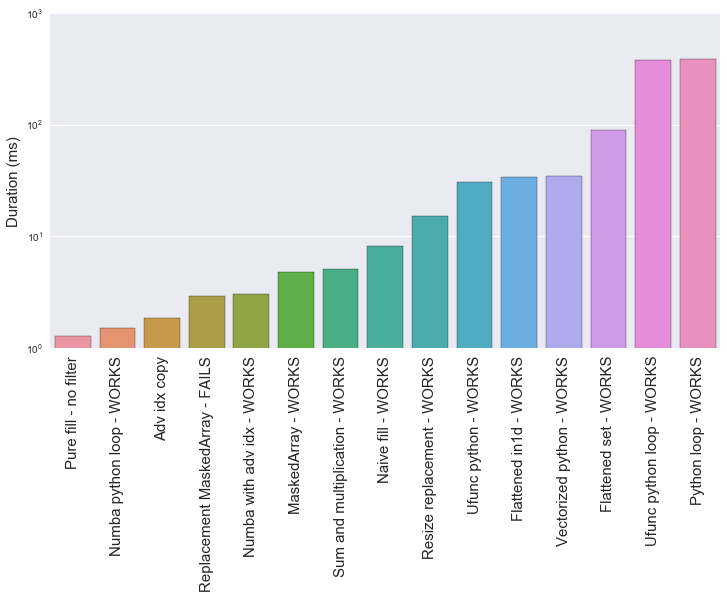

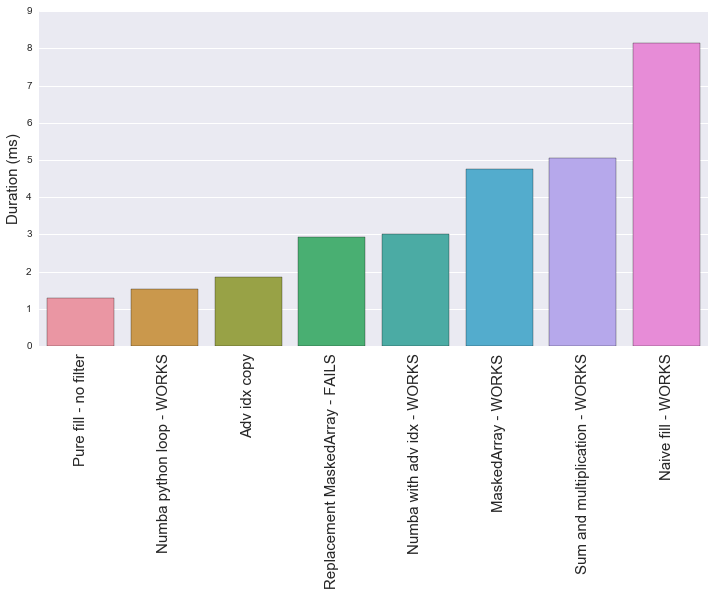

In [43]:
fig = seaborn.barplot(col, t, order=np.array(col)[np.argsort(t)])
seaborn.plt.xticks(rotation='vertical', fontsize=15)
seaborn.plt.ylabel("Duration (ms)", fontsize=15)
fig.axes.set_yscale('log')
seaborn.plt.show()

fig = seaborn.barplot(np.array(col)[np.argsort(t)][0:8], np.array(t)[np.argsort(t)][0:8])
seaborn.plt.xticks(rotation='vertical', fontsize=15)
seaborn.plt.ylabel("Duration (ms)", fontsize=15)
seaborn.plt.show()